# Sensitivity to extent

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pylandstats as pls
import seaborn as sns
import swisslandstats as sls
from shapely.geometry import Point

from swiss_urbanization.data import settings

In [17]:
# set default seaborn style
sns.set()

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

# keyword arguments to be passed to `savefig`
savefig_kws = {
    'dpi': 300,
    'bbox_inches': 'tight',
    'pad_inches': 0
}

In [3]:
urban_class = settings.EXTRACTS_URBAN
nodata = settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

class_metrics = [
    'area_mn', 'proportion_of_landscape', 'largest_patch_index',
    'edge_density', 'fractal_dimension_am',
    'euclidean_nearest_neighbor_mn', 'landscape_shape_index',
    'patch_density'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

buffer_dists = list(range(5000, 25000, 5000))
# TODO: change hardcoded points and use overpass API filtering by tag
# `admin_centre:4=yes`
base_mask_dict = {
    'bern': Point(7.4514512, 46.9482713),
    'lausanne': Point(6.6327025, 46.5218269),
    'zurich': Point(8.5414061, 47.3769434)
}
base_mask_crs = {'init':'epsg:4326'}

In [4]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    base_mask = base_mask_dict[agglomeration_slug]
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res,
                nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalBufferAnalysis(
        landscapes,
        base_mask,
        buffer_dists=buffer_dists,
        base_mask_crs=base_mask_crs,
        landscape_crs=ldf.crs,
        landscape_transform=ldf.get_transform(),
        metrics=class_metrics + landscape_metrics,
        classes=[urban_class],
        dates=dates)

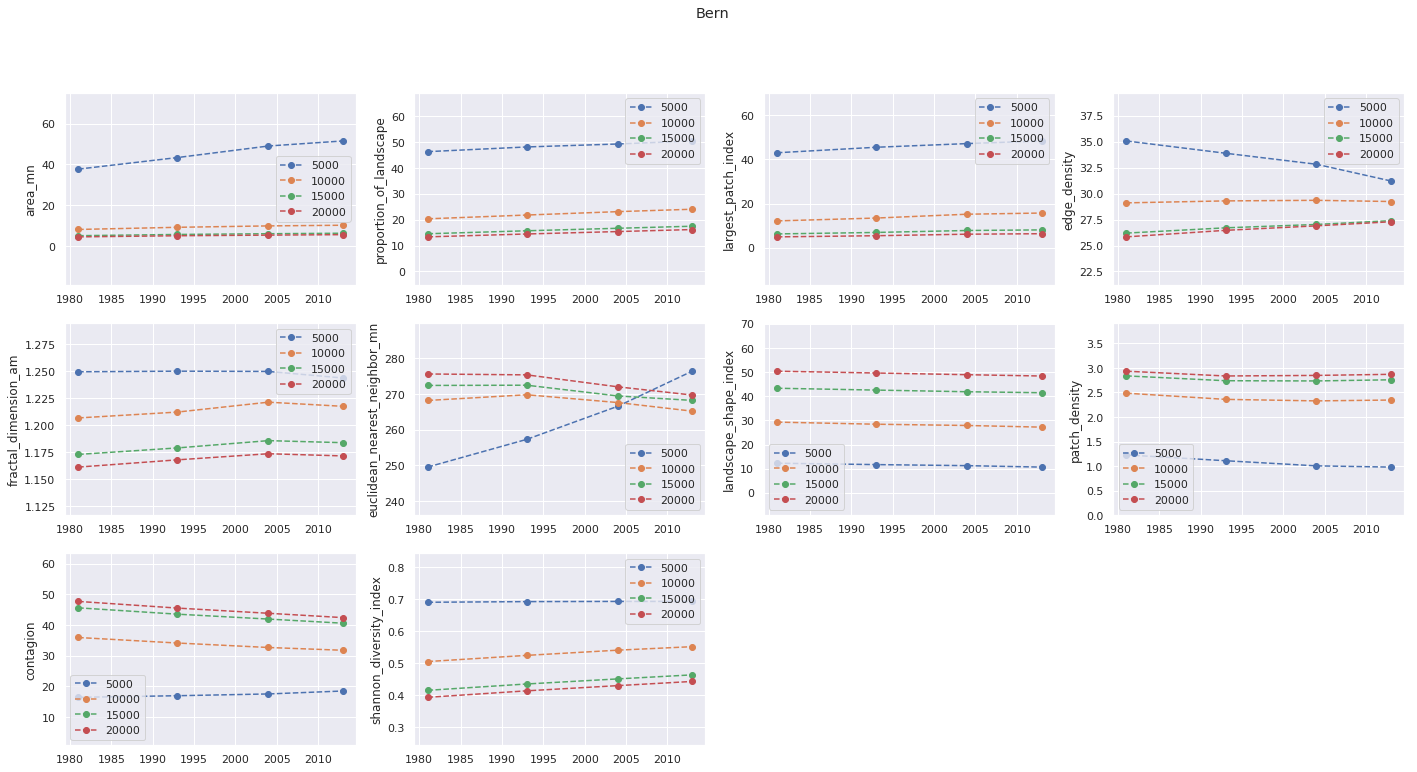

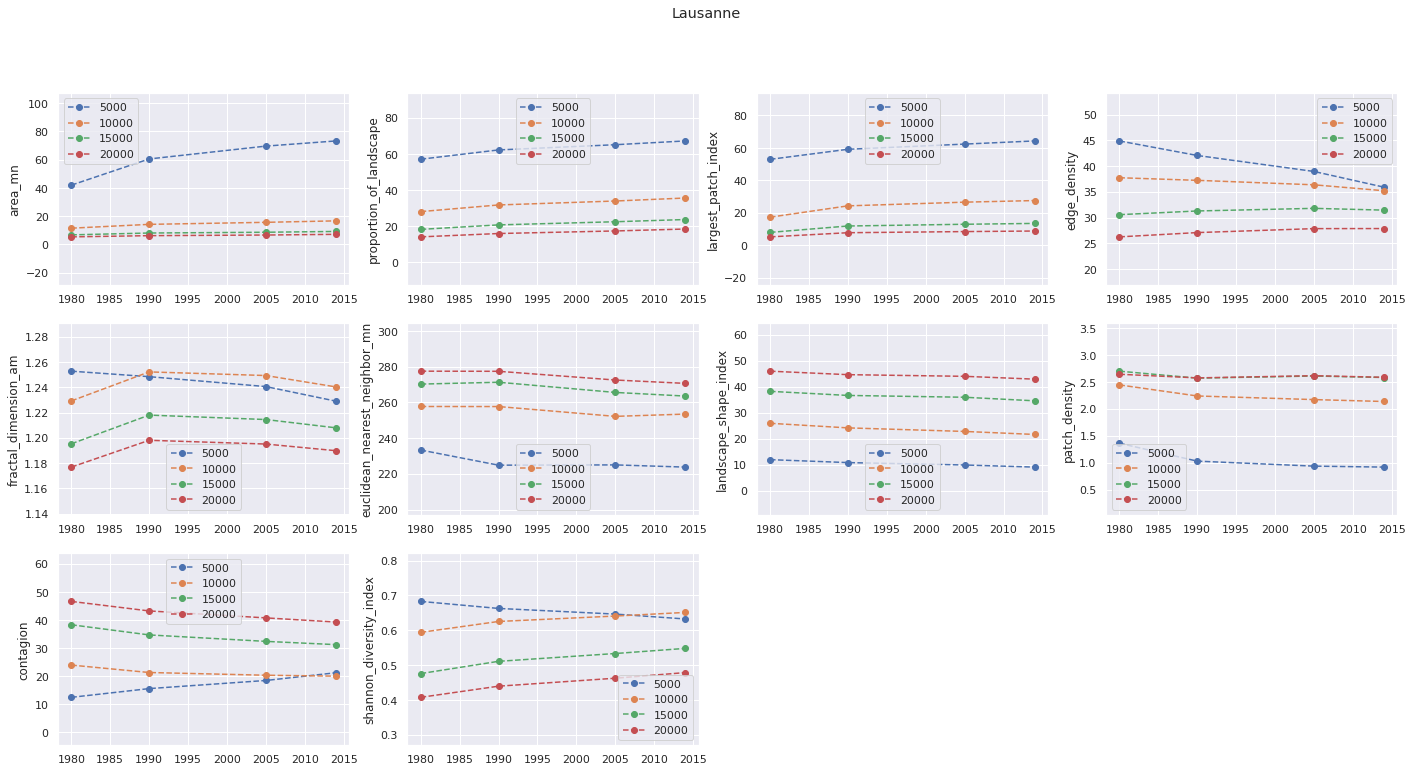

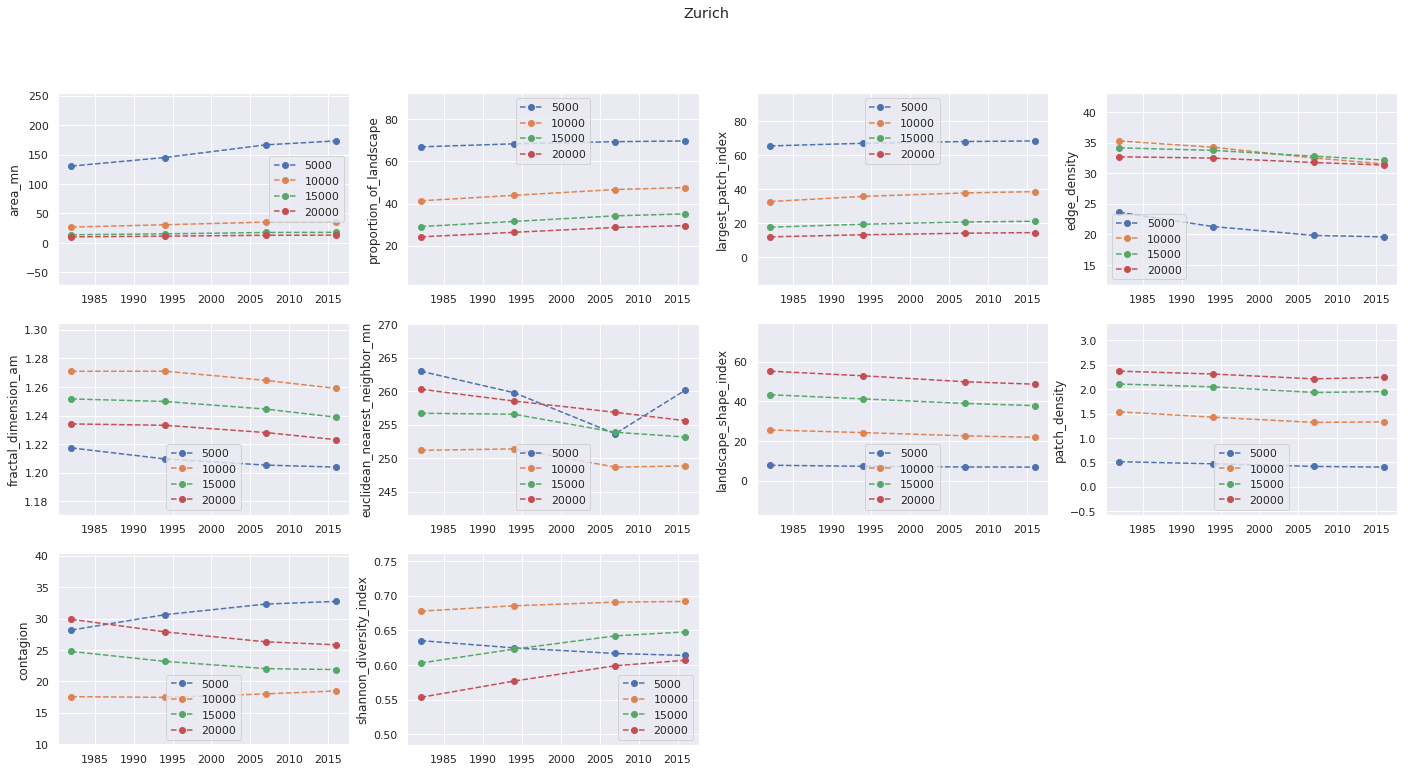

In [19]:
def plot_metric(fig, num_rows, num_cols, i, agglomeration_stba, metric, class_val=None):
    ax = fig.add_subplot(num_rows, num_cols, i)
    agglomeration_stba.plot_metric(
        metric, class_val=class_val, ax=ax)
    ax.margins(y=.5)
    ax.legend()
    

num_cols = 4
num_metrics = len(class_metrics) + len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

for agglomeration_slug in agglomeration_slugs:
    agglomeration_stba = agglomeration_dict[agglomeration_slug]
    fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))
    fig.suptitle(agglomeration_slug.capitalize())
    for i, metric in enumerate(class_metrics, start=1):
        plot_metric(fig, num_rows, num_cols, i, agglomeration_stba, metric, class_val=urban_class)
    for i, metric in enumerate(landscape_metrics, start=len(class_metrics) + 1):
        plot_metric(fig, num_rows, num_cols, i, agglomeration_stba, metric)

## Landscape plots

In [20]:
sns.set_style({'axes.grid': False, 'image.cmap': 'ocean_r'})

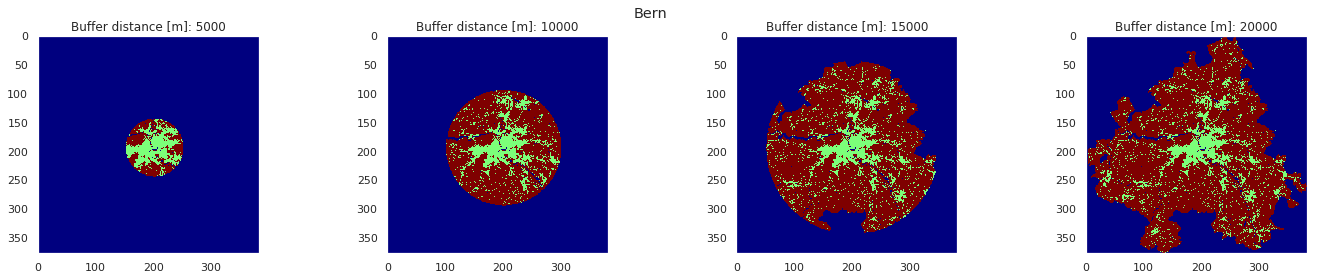

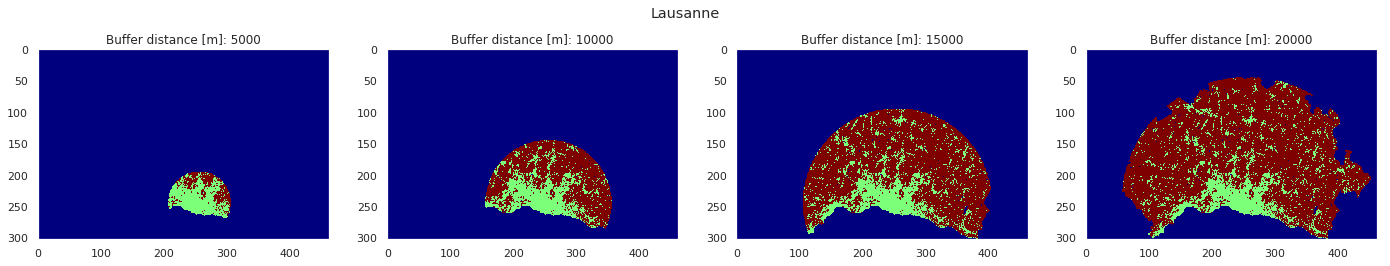

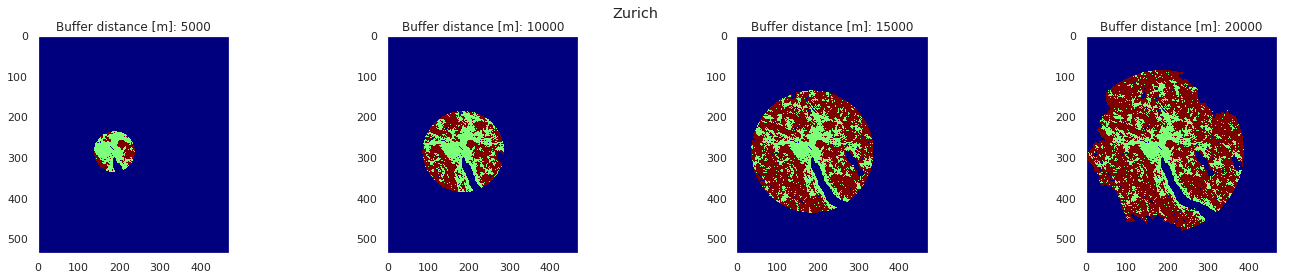

In [21]:
def plot_landscape_buffers(agglomeration_stba):
    num_cols = len(agglomeration_stba.stas)
    fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * figwidth, figheight))
                             
    for i in range(num_cols):
        ax = axes[i]
        # just plot for the last temporal snapshot
        agglomeration_stba.stas[i].landscapes[-1].plot_landscape(ax=ax)
        ax.set_title(f'Buffer distance [m]: {agglomeration_stba.buffer_dists[i]}')

    return fig

for agglomeration_slug in agglomeration_slugs:
    agglomeration_stba = agglomeration_dict[agglomeration_slug]
    fig = plot_landscape_buffers(agglomeration_stba)
    fig.suptitle(agglomeration_slug.capitalize())